In [1]:
import sys; sys.path.insert(0, '..')

import sys
import torch
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output, Javascript

from multiagent.environment import MultiAgentEnv
import multiagent.scenarios as scenarios
from notebook_utils import plot, mean_filter
import pytorch_drl.models.ddpg_models as models
from pytorch_drl.utils.exploration import *
from pytorch_drl.algs.maddpg import MADDPG

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
sc_simple = "simple"
sc_simple_adversary = "simple_adversary"
sc_simple_crypto = "simple_crypto"
sc_simple_push = "simple_push"
sc_simple_reference = "simple_reference"
sc_simple_speaker_listener = "simple_speaker_listener"
sc_simple_spread = "simple_spread"
sc_simple_tag = "simple_tag"
sc_simple_world_comm = "simple_world_comm"

In [3]:
# https://github.com/openai/multiagent-particle-envs/blob/master/make_env.py
# doesn't end
def get_env(scenario_name):
    scenario = scenarios.load(scenario_name + ".py").Scenario()
    world = scenario.make_world()
    env = MultiAgentEnv(world, scenario.reset_world, scenario.reward, scenario.observation)
    return env

## Create environment

In [4]:
env = get_env(sc_simple)

/home/selo/Envs/ml-agent_/gym/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [5]:
print("action_space: ", env.action_space)
print(env.action_space[0])
print("discrete_action_input: ", env.discrete_action_input)
print("discrete_action_space: ", env.discrete_action_space)
print("n: ", env.n)
print("observation_space: ", env.observation_space)
print("----------------------------------------------")
print(env.reset())

action_space:  [Discrete(5)]
Discrete(5)
discrete_action_input:  False
discrete_action_space:  True
n:  1
observation_space:  [Box(4,)]
----------------------------------------------
[array([ 0.        ,  0.        , -0.58370326, -0.67623465])]


In [6]:
env.step([np.eye(5)[1], np.eye(5)[1], np.eye(5)[1]])

([array([ 0.5       ,  0.        , -0.63370326, -0.67623465])],
 [-0.8588731232596569],
 [False],
 {'n': [{}]})

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")#
#device = "cpu"
print("Device:", device)

Device: cuda:0


## Define networks for different algorithms

In [6]:
def copy_network(network1, network2):
    network2.load_state_dict(network1.state_dict())

In [10]:
n_agents = env.n
action_sizes = [space.n for space in env.action_space]
state_sizes = [np.prod(space.shape) for space in env.observation_space]
total_size = np.sum(action_sizes) + np.sum(state_sizes)

In [11]:
# random agent
for _ in range(5):
    t = 0
    score = np.zeros(n_agents)
    states = env.reset()
    for q in range(50):
        actions = [np.eye(action_sizes[i])[np.random.randint(action_sizes[i])] for i in range(n_agents)]
        #print("-------------\n".join(map(str, actions)))
        states, rewards, dones, _ = env.step(actions)
        score += rewards
        t += 1
        #env.render()
        if dones[0]:
            break
    else:
        print("-----------------------------------------------------")
        continue

    print("Took {} steps.".format(t))
    print("Scores of each agent: {}".format(score))
    print("Avg score: {}".format(np.mean(score)))
    print("-----------------------------------------------------")
env.close()

-----------------------------------------------------
-----------------------------------------------------
-----------------------------------------------------
-----------------------------------------------------
-----------------------------------------------------


## MADDPG Test

Test the MADDPG algorithm

In [91]:
env = get_env(sc_simple)
n_agents = env.n
action_sizes = [space.n for space in env.action_space]
state_sizes = [np.prod(space.shape) for space in env.observation_space]
total_size = np.sum(action_sizes) + np.sum(state_sizes)

value_nets = [models.MADDPGValueNetwork(total_size-action_sizes[i], action_sizes[i]) for i in range(n_agents)]
value_net_targets = [models.MADDPGValueNetwork(total_size-action_sizes[i], action_sizes[i]) for i in range(n_agents)]
for i in range(n_agents):
    copy_network(value_nets[i], value_net_targets[i])

policy_nets = [models.DDPGDiscrete(state_sizes[i], action_sizes[i]) for i in range(n_agents)]
policy_net_targets = [models.DDPGDiscrete(state_sizes[i], action_sizes[i]) for i in range(n_agents)]
for i in range(n_agents):
    copy_network(policy_nets[i], policy_net_targets[i])


agent = MADDPG(policy_nets=policy_nets,
                policy_net_targets=policy_net_targets,
                value_nets=value_nets,
                value_net_targets=value_net_targets,
                gamma=0.95, 
                lr_val=1e-2,
                lr_pol=1e-2,
                buf_size=int(1e6),
                batch_size=1024,
                tau=1e-2,
                device="cpu", #device,
                max_grad_norm=0.5,
                warm_up=0,
                env=env,
                seed=100,
                learn_every=100,
                )
    
scores = agent.train(n_episodes=1000, max_t=50, test_every=10, max_score=-0)

# plot the training:
#plot(scores)

Average test score: [-959.97834694], e: 990                   

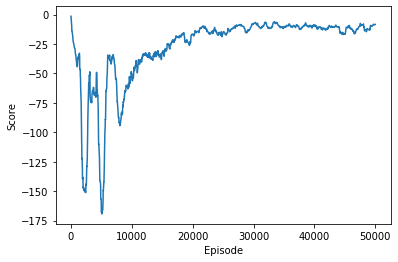

In [92]:
plot(scores, 1000)

### Trained Agent Demonstration

In [ ]:
agent.test(50, 5, True)

### Simple Adversary

In [9]:
env = get_env(sc_simple_speaker_listener)
n_agents = env.n
action_sizes = [space.n for space in env.action_space]
state_sizes = [np.prod(space.shape) for space in env.observation_space]
total_size = np.sum(action_sizes) + np.sum(state_sizes)

value_nets = [models.MADDPGValueNetwork(total_size-action_sizes[i], action_sizes[i]) for i in range(n_agents)]
value_net_targets = [models.MADDPGValueNetwork(total_size-action_sizes[i], action_sizes[i]) for i in range(n_agents)]
for i in range(n_agents):
    copy_network(value_nets[i], value_net_targets[i])

policy_nets = [models.DDPGDiscrete(state_sizes[i], action_sizes[i]) for i in range(n_agents)]
policy_net_targets = [models.DDPGDiscrete(state_sizes[i], action_sizes[i]) for i in range(n_agents)]
for i in range(n_agents):
    copy_network(policy_nets[i], policy_net_targets[i])


agent = MADDPG(policy_nets=policy_nets,
                policy_net_targets=policy_net_targets,
                value_nets=value_nets,
                value_net_targets=value_net_targets,
                gamma=0.95, 
                lr_val=1e-2,
                lr_pol=1e-2,
                buf_size=int(1e6),
                batch_size=1024,
                tau=1e-2,
                device=device,
                max_grad_norm=0.5,
                warm_up=0,
                env=env,
                seed=100,
                learn_every=100,
                )
    
scores = agent.train(n_episodes=3000, max_t=50, test_every=10, max_score=-0)

# plot the training:
#plot(scores)

Average test score: [-3473.64858362 -3473.64858362], e: 20                  

../torch/csrc/utils/python_arg_parser.cpp:698: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, Number alpha)


Average test score: [-41.84770357 -41.84770357], e: 2990                     